In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk
import spacy
nlp=spacy.load("en_core_web_lg")

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [2]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [3]:
df = pd.read_excel("D:/NLP/data/bank_a_sentiment_analysis_translated_inputdata.xlsx")
df_test=pd.read_excel("D:/NLP/data/bank_a_sentiment_analysis_translated_inputdata_unseen.xlsx")
print(df.info(),"Shape:",df.shape)
df = df[["translated_review","actual_sentiment"]]
df_test = df_test[["translated_review","actual_sentiment"]]
df=df[df["actual_sentiment"]!="Neutral"]
df_test=df_test[df_test["actual_sentiment"]!="Neutral"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          3486 non-null   float64
 1   translated_review  3481 non-null   object 
 2   actual_sentiment   3482 non-null   object 
dtypes: float64(1), object(2)
memory usage: 81.8+ KB
None Shape: (3486, 3)


In [4]:
# Since we cannot impute text data. Therefore, removing empty/blank/NA values from dataset.
df=df.dropna().reset_index()
df=df.drop("index",axis=1)
df_test=df_test.dropna().reset_index()
df_test=df_test.drop("index",axis=1)

In [5]:
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)

    return "".join(cleantext)

df['preprocessed_text']=df['translated_review'].map(lambda s:preprocess(s)) 
df_test['preprocessed_text']=df_test['translated_review'].map(lambda s:preprocess(s)) 

In [6]:
df['preprocessed_text'] = df['preprocessed_text'].str.replace('[^\w\s]','')
df_test['preprocessed_text'] = df_test['preprocessed_text'].str.replace('[^\w\s]','')

C:\Users\SAURAB~1.MIS\AppData\Local\Temp/ipykernel_37640/4154870127.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['preprocessed_text'] = df['preprocessed_text'].str.replace('[^\w\s]','')
C:\Users\SAURAB~1.MIS\AppData\Local\Temp/ipykernel_37640/4154870127.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['preprocessed_text'] = df_test['preprocessed_text'].str.replace('[^\w\s]','')


In [7]:
# StopWords Removal
from nltk.corpus import stopwords

# stopwords = en.Defaults.stop_words
stop = stopwords.words('english')
not_stop=["no","not","too"]
for i in not_stop:
    if i in stop:
        stop.remove(i)
df['clean_text'] = df['preprocessed_text'].apply(lambda x: " ".join(i for i in x.split() if i not in stop))
# Stemming
df["cleaned_text"]=df["clean_text"].apply(lambda x: " ".join(token.lemma_ for token in nlp(x) if not (token.like_num or token.is_punct or token.is_space or len(token)==1)))
df=df[["cleaned_text","actual_sentiment"]]

df_test['clean_text'] = df_test['preprocessed_text'].apply(lambda x: " ".join(i for i in x.split() if i not in stop))
# Stemming
df_test["cleaned_text"]=df_test["clean_text"].apply(lambda x: " ".join(token.lemma_ for token in nlp(x) if not (token.like_num or token.is_punct or token.is_space or len(token)==1)))
df_test=df_test[["cleaned_text","actual_sentiment"]]
df

,cleaned_text,actual_sentiment
0,branch san marco evangelista employee include ...,Positive
1,commission withdraw money counter theft,Negative
2,promote support small business territory,Positive
3,account holder many year operate mainly equity...,Positive
4,even like old site must say among good among g...,Positive
...,...,...
2426,helpful staff helpful always smile,Positive
2427,collect sheet ask,Negative
2428,reliable safe courtesy phone always helpful help,Positive
2429,poor interest customer,Negative


In [8]:
text_len = []
for text in df.cleaned_text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df['text_len'] = text_len

In [9]:
text_len_test = []
for text in df_test.cleaned_text:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df_test['text_len'] = text_len_test

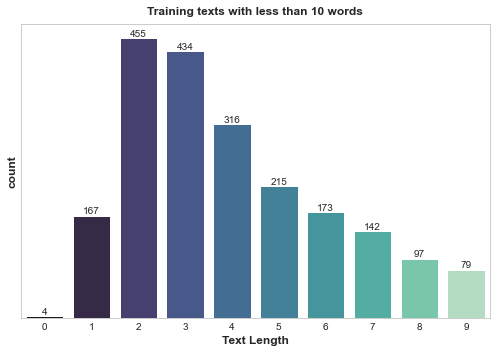

In [10]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training texts with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('Text Length')
plt.show()

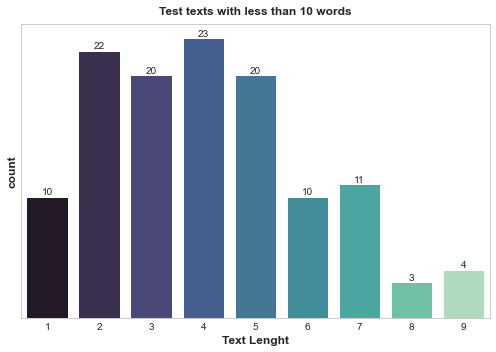

In [11]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test texts with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('Text Lenght')
plt.show()

In [12]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [13]:
token_lens = []

for txt in df['cleaned_text'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [14]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 77


In [15]:
token_lens = []

for i,txt in enumerate(df['cleaned_text'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}") 

In [16]:
df['token_lens'] = token_lens

In [17]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,cleaned_text,actual_sentiment,text_len,token_lens
1784,problem reception bank transfer arrive late re...,Negative,64,77
190,feel good banca xxyyzz identify person follow ...,Negative,54,76
189,feel good banca xxyyzz identify person follow ...,Positive,54,76
1153,characteristic proximity knowledge territory t...,Negative,58,70
67,keep pre authorize euro rechargeable xxyyzz ca...,Negative,45,67
168,new version internet banking not satisfy need ...,Negative,56,65
177,despite home banking portal update many operat...,Negative,49,65
2074,belong banca arditi galati tricase le bank alm...,Negative,45,59
1570,would not advise would even criticize bank ban...,Negative,49,56
127,new home banking definitely step back block ac...,Negative,52,56


In [18]:
df = df.sample(frac=1).reset_index(drop=True)

In [19]:
token_lens_test = []

for txt in df_test['cleaned_text'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [20]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 77


In [21]:
token_lens_test = []

for i,txt in enumerate(df_test['cleaned_text'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

In [22]:
df_test['token_lens'] = token_lens_test

In [23]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

,cleaned_text,actual_sentiment,text_len,token_lens
11,previous negative assessment base assumption s...,Negative,69,77
36,exactly everything promise correspond realt in...,Positive,21,35
2,lower vote give previous evaluation since impa...,Negative,20,24
90,fine enter bank always smile always greet even...,Positive,18,22
49,year customer always meet good employee hope a...,Positive,18,20
55,congratulations banca xxyyzz director martina ...,Positive,9,20
3,request fundamental service would use account ...,Negative,17,19
6,sister find well square piazza castello turin ...,Negative,14,18
118,feel good bank excellent app manage easy intui...,Positive,13,17
67,modern easy use online clear always improve te...,Positive,12,17


In [24]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [25]:
df['actual_sentiment'].value_counts()

Positive    1831
Negative     600
Name: actual_sentiment, dtype: int64

In [26]:
df['actual_sentiment'] = df['actual_sentiment'].map({'Negative':0,'Neutral':1,'Positive':2})
df_test['actual_sentiment'] = df_test['actual_sentiment'].map({'Negative':0,'Neutral':1,'Positive':2})

In [27]:
df_test['actual_sentiment'].value_counts()

2    106
0     34
Name: actual_sentiment, dtype: int64

In [28]:
X = df['cleaned_text'].values
y = df['actual_sentiment'].values

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [30]:
X_test = df_test['cleaned_text'].values
y_test = df_test['actual_sentiment'].values

In [31]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [32]:
y_train_le

array([0, 2, 2, ..., 2, 0, 2], dtype=int64)

In [33]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [34]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 2187
VALIDATION DATA: 244
TESTING DATA: 140


In [35]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [36]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [37]:
nb_clf = MultinomialNB()
rf_clf= RandomForestClassifier(n_estimators=50,max_depth=5,min_samples_split=5,class_weight="balanced")

In [38]:
nb_clf.fit(X_train_tf, y_train_le)
rf_clf.fit(X_train_tf, y_train_le)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=50)

In [39]:
nb_pred = nb_clf.predict(X_test_tf)
rf_pred = rf_clf.predict(X_test_tf)

In [40]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Positive']))
print('\tClassification Report for Random Forest:\n\n',classification_report(y_test_le,rf_pred, target_names=['Negative', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.93      0.38      0.54        34
    Positive       0.83      0.99      0.91       106

    accuracy                           0.84       140
   macro avg       0.88      0.69      0.72       140
weighted avg       0.86      0.84      0.82       140

	Classification Report for Random Forest:

               precision    recall  f1-score   support

    Negative       0.83      0.74      0.78        34
    Positive       0.92      0.95      0.94       106

    accuracy                           0.90       140
   macro avg       0.88      0.84      0.86       140
weighted avg       0.90      0.90      0.90       140



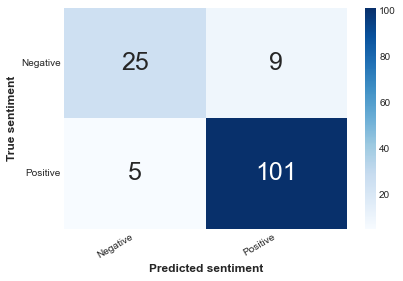

In [41]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",annot_kws={"size":25})
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test_le, rf_pred)
df_cm = pd.DataFrame(cm, index=["Negative","Positive"], columns=["Negative","Positive"])
show_confusion_matrix(df_cm)

In [42]:
MAX_LEN=85

In [43]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [44]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [45]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

In [46]:
# def create_model(bert_model, max_len=MAX_LEN):
    
#     ##params###
#     opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
#     loss = tf.keras.losses.CategoricalCrossentropy()
#     accuracy = tf.keras.metrics.CategoricalAccuracy()


#     input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
#     attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
#     embeddings = bert_model([input_ids,attention_masks])[1]
    
#     output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
#     model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
#     model.compile(opt, loss=loss, metrics=accuracy)
    
    
#     return model

In [47]:
# model = create_model(bert_model, MAX_LEN)
# model.summary()

In [48]:
# history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

In [49]:
# result_bert = model.predict([test_input_ids,test_attention_masks])

In [50]:
# y_pred_bert =  np.zeros_like(result_bert)
# y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [51]:
# print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

In [52]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

In [53]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

75

In [54]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)


In [55]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [56]:
def create_model(bert_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [57]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [58]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 85)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 85)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 85,                                            

In [59]:
val_input_ids

array([[    0,   417, 39116, ...,     1,     1,     1],
       [    0,  3463, 39462, ...,     1,     1,     1],
       [    0, 22466,   385, ...,     1,     1,     1],
       ...,
       [    0,  8396,     2, ...,     1,     1,     1],
       [    0,  3463, 39462, ...,     1,     1,     1],
       [    0, 19709,  4453, ...,     1,     1,     1]])

In [60]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=10, batch_size=32)

Epoch 1/10
69/69 [==============================] - 2306s 33s/step - loss: 0.4620 - categorical_accuracy: 0.7984 - val_loss: 0.3440 - val_categorical_accuracy: 0.8811
Epoch 2/10
69/69 [==============================] - 2208s 32s/step - loss: 0.2668 - categorical_accuracy: 0.8985 - val_loss: 0.2899 - val_categorical_accuracy: 0.9057
Epoch 3/10
69/69 [==============================] - 2383s 35s/step - loss: 0.1848 - categorical_accuracy: 0.9351 - val_loss: 0.3161 - val_categorical_accuracy: 0.8893
Epoch 4/10
69/69 [==============================] - 2163s 31s/step - loss: 0.1359 - categorical_accuracy: 0.9566 - val_loss: 0.3717 - val_categorical_accuracy: 0.8934
Epoch 5/10
69/69 [==============================] - 2342s 34s/step - loss: 0.1260 - categorical_accuracy: 0.9611 - val_loss: 0.3692 - val_categorical_accuracy: 0.8975
Epoch 6/10
69/69 [==============================] - 2322s 34s/step - loss: 0.0965 - categorical_accuracy: 0.9684 - val_loss: 0.3525 - val_categorical_accuracy: 0.893

In [61]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

5/5 [==============================] - 32s 5s/step


In [62]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [63]:

print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.92      0.71      0.80        34
    Positive       0.91      0.98      0.95       106

   micro avg       0.91      0.91      0.91       140
   macro avg       0.92      0.84      0.87       140
weighted avg       0.91      0.91      0.91       140
 samples avg       0.91      0.91      0.91       140



In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_roberta, target_names=["Negative","Positive"]))

              precision    recall  f1-score   support

    Negative       0.92      0.71      0.80        34
    Positive       0.91      0.98      0.95       106

   micro avg       0.91      0.91      0.91       140
   macro avg       0.92      0.84      0.87       140
weighted avg       0.91      0.91      0.91       140
 samples avg       0.91      0.91      0.91       140



In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_roberta)

0.9142857142857143

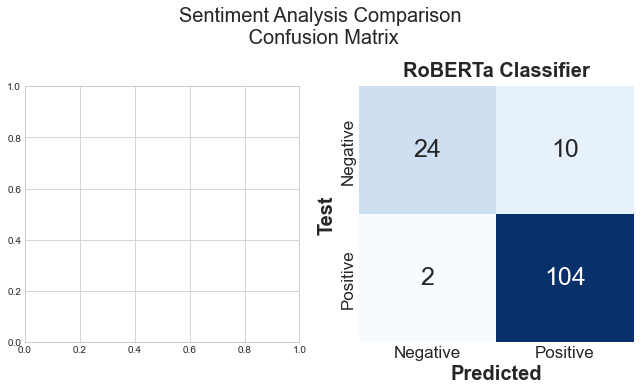

In [66]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


# sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

# ax[0].set_title('BERT Classifier', fontsize=20)
# ax[0].set_yticklabels(labels, fontsize=17);
# ax[0].set_xticklabels(labels, fontsize=17);
# ax[0].set_ylabel('Test', fontsize=20)
# ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()